## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn7-3.ipynb에서 cart의 초기 위치 범위를 (-0.05, 0.05)에서 (-3.8, 3.8)로 만들어서, 알아서 중심으로 이동하도록 학습되는지 확인

* reward -= distance / 4.8 * 2로 디자인하니 처음에 너무 치우쳐져 생성된 경우에 바로 pole을 쓰러트려 음수 보상을 받는 것을 피하는 전략이 나왔음
* reward -= distance / 4.8으로 디자인해야겠다

In [4]:
import gymnasium
from gymnasium.envs.registration import register
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [5]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [6]:
register(
    id='CartPole-v2',
    entry_point='cartpole_v2:CartPoleEnv',
    max_episode_steps=500,
)
env = gymnasium.make('CartPole-v2')
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q)

/home/seokj/workspace/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment CartPole-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [7]:
lr = 0.0001
discount = 0.99
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(q.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [8]:
scores = []
action_count = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    score = 0
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        position = next_state[0]
        distance = abs(position)
        reward -= distance / 4.8 * 2
        score += reward
        replay_buffer.append(state, action, reward, next_state, terminated)
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(1)).squeeze()
            next_state_values = torch.zeros_like(state_action_values)
            next_state_values[~batch.terminated] = target_q(batch.next_state[~batch.terminated]).max(1).values
            expected_state_action_values = next_state_values * discount + batch.reward
            loss = criterion(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict()
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    scores.append(score)

    if (i + 1) % 100 == 0:
        print(np.mean(scores[-100:]))

 17%|█▋        | 100/600 [00:03<00:15, 32.41it/s]

5.073489779053197


 33%|███▎      | 198/600 [00:26<08:23,  1.25s/it]

19.758196433851456


 50%|█████     | 300/600 [02:18<05:24,  1.08s/it]

130.5219761060273


 67%|██████▋   | 403/600 [04:06<02:16,  1.45it/s]

192.05990219711921


 83%|████████▎ | 497/600 [06:28<02:59,  1.75s/it]

168.84371833764456


100%|██████████| 600/600 [09:09<00:00,  1.09it/s]

182.82282741160387


In [9]:
len(replay_buffer)

10000

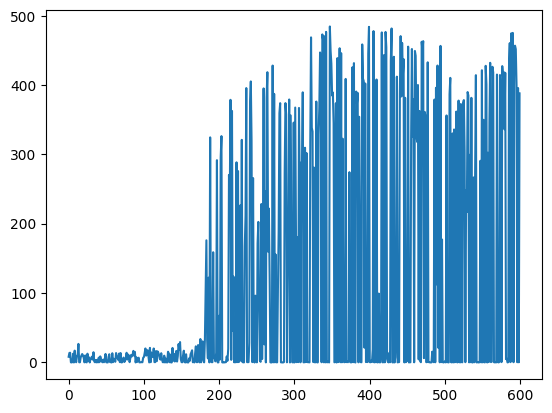

In [10]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [14]:
env = gymnasium.make('CartPole-v2', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        position = next_state[0]
        distance = abs(position)
        reward -= distance / 4.8 * 2
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[422.31582223750615,
 397.25175543824065,
 -0.4924337466557822,
 -0.05691770712534594,
 -0.3081836700439453,
 395.56756707514677,
 305.4301088675854,
 392.31897519717035,
 359.1886389512608,
 414.51682343389945]

In [12]:
env.close()

In [13]:
env = gymnasium.make('CartPole-v1')